In [1]:
import numpy as np

class Agent: 
    def __init__(self, strategy = 1, strategy_chromosome = list, nr_concerts = int, festival_duration=int):
        self.dist_from_stage = 0
        self.position_utility = 0
        self.waiting_utility_history = np.zeros(festival_duration)
        self.waited_time = 0
        self.strategy = strategy 
        self.strategy_chromosome = strategy_chromosome
        self.position_utility_history = np.zeros(festival_duration)
        self.concert_history = np.ones(festival_duration, dtype=int)*(nr_concerts-1)
        self.concert_history[0] = 0 #start at first concert 
        self.time_to_leave = np.random.choice([1,2,3,4,5]) 

class Concert:
    def __init__(self, len_rows = int, capacity = int, duration = int, nr_of_agents = int):
        self.len_rows = len_rows
        self.nr_agents = 0
        self.nr_waiting_agents = 0
        self.capacity = capacity
        self.nr_rows = np.ceil(capacity/len_rows)
        self.duration = duration #timesteps
        self.agents = np.zeros(nr_of_agents)

    def add_agent(self):
        self.nr_agents += 1

def get_dist_from_stage(concert):
    dist_from_stage = np.floor((concert.nr_agents) / concert.len_rows)
    return dist_from_stage

def get_placement_utility(concert):
    placement_factor = 5
    #stepwise by which row the agent is in, sensitive to concert row length
    dist_from_stage = get_dist_from_stage(concert)
    utility = placement_factor * (concert.nr_rows - dist_from_stage) / concert.nr_rows
    return utility, dist_from_stage

def get_waiting_utility():
    waiting_factor = 1
    utility = -1 * waiting_factor
    return utility


In [2]:
def move_agent_to_next_concert(agent, idx, current_concert, next_concert, timestep, global_time):
    timesteps_left = current_concert.duration-timestep
    # Fill up agent's waiting utilities until the next concert
    for k in range(0,timesteps_left-1):
        agent.waiting_utility_history[global_time+k] = get_waiting_utility()
        agent.waited_time -= 1
    
    # Find position utility at next concert, add to history
    position_utility, dist_from_stage = get_placement_utility(next_concert)
    agent.position_utility = position_utility
    agent.dist_from_stage = dist_from_stage
    agent.position_utility_history[global_time + timesteps_left-1] = position_utility

    # Populate the next concert
    next_concert.add_agent() 
    next_concert.agents[idx] = 1

In [3]:
from itertools import product
import numpy as np

# Generate all valid chromosomes where permutations matter
values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
target_sum = 1.0
length = 5

# Helper function to filter valid chromosomes
def valid_chromosomes():
    # Generate all possible products (permutations with replacement)
    for combo in product(values, repeat=length):
        if abs(sum(combo) - target_sum) < 1e-9:  # Check if the sum is 1.0
            yield combo

all_combinations = list(valid_chromosomes())


In [4]:
strategies = np.arange(1, len(all_combinations) + 1)
probabilities = []
for strategy in strategies:
    probabilities.append(1/len(strategies))

nr_of_agents = len(all_combinations)*2
nr_concerts = 20
nr_rows = nr_of_agents*0.1
concert_duration = 5
move_forward_option = False
mistake_rate = 0


In [5]:
def initialize_festival(probabilities):
    festival_duration = nr_concerts*concert_duration
    agents = []
    concerts = []

    for _ in range (nr_of_agents):
        strategy_idx = np.random.choice(len(strategies), p=probabilities)
        strategy_sample = strategies[strategy_idx]
        agent = Agent(strategy = strategy_sample, 
                        nr_concerts=nr_concerts, festival_duration = festival_duration, 
                        strategy_chromosome= all_combinations[strategy_idx])
        agents.append(agent)

    for _ in range(nr_concerts):
        concert = Concert(capacity = nr_of_agents, len_rows=nr_of_agents/nr_rows,
                        duration = concert_duration, nr_of_agents = nr_of_agents)
        concerts.append(concert)

    #Add all agents to the starting concerts in a random order
    shuffled_indices = np.random.permutation(nr_of_agents)
    for i in range (nr_of_agents):
        idx = shuffled_indices[i]
        position_utility = 0 #Starting utility is zero
        concerts[0].add_agent() 
        concerts[0].agents[idx] = 1
        agents[idx].position_utility = position_utility
        concerts[0].add_agent() 
        
    return agents, concerts


In [6]:
def initialize_first_festival(nr_of_agents,nr_of_strategies):
    festival_duration = nr_concerts*concert_duration
    agents = []
    concerts = []
    agents_per_strategy = int(nr_of_agents / nr_of_strategies)

    for strategy_idx in range (nr_of_strategies):
        strategy_sample = strategies[strategy_idx]
        
        # Create equally many agents of each strategy at the first festival
        for _ in range(agents_per_strategy):
            agent = Agent(strategy = strategy_sample, 
                        nr_concerts=nr_concerts, festival_duration = festival_duration, 
                        strategy_chromosome= all_combinations[strategy_idx])
            agents.append(agent)

    for _ in range(nr_concerts):
        concert = Concert(capacity = nr_of_agents, len_rows=nr_of_agents/nr_rows,
                        duration = concert_duration, nr_of_agents = nr_of_agents)
        concerts.append(concert)

    #Add all agents to the starting concerts in a random order
    shuffled_indices = np.random.permutation(nr_of_agents)
    for i in range (nr_of_agents):
        idx = shuffled_indices[i]
        position_utility = 0 #Starting utility is zero
        concerts[0].add_agent() 
        concerts[0].agents[idx] = 1
        agents[idx].position_utility = position_utility
        concerts[0].add_agent() 
        
    return agents, concerts


In [7]:
def simulate_one_festival(agents, concerts):
    global_time = 0

    for concert_idx in range(0,len(concerts)-1):
        current_concert = concerts[concert_idx]
        next_concert = concerts[concert_idx + 1]

        if (concert_idx > 0):
            for agent in agents:
                # startegies are now a probability vector of when to leave
                agent.time_to_leave = np.random.choice([1, 2, 3, 4, 5], p = agent.strategy_chromosome)
                # Agents can make mistakes on when to leave
                if (np.random.rand() <= mistake_rate):
                    agent.time_to_leave = np.random.randint(1, current_concert.duration+1)

                agent.waited_time = 0

        for timestep in range(0,current_concert.duration):
            # Update time
            global_time += 1
            nr_agents_leaving = 0
            staying_agents = []

            shuffled_indices = np.random.permutation(nr_of_agents)
            for j in range (nr_of_agents):
                idx = shuffled_indices[j]
                
                if (current_concert.agents[idx] == 0):  
                    # Not attending the concert 
                    continue

                # Get action
                if (agents[idx].time_to_leave == timestep+1):
                    action = 'leave'
                else: 
                    action = 'stay'
                
                if (action == 'leave'):
                    # Leave current concert
                    current_concert.agents[idx] = 0
                    nr_agents_leaving += 1
                    
                    for k in range(0,current_concert.duration-timestep):
                        #Update agent's concert history
                        agents[idx].concert_history[global_time + k] = concert_idx + 1

                    # Set agent up at the next concert
                    move_agent_to_next_concert(agents[idx], idx, current_concert, next_concert, timestep, global_time)
                    
                else: #they stay at the concert one more time step
                    #Store staying agents
                    staying_agents.append(idx)
            
            # Update position utility for agents that stay
            current_concert.nr_agents = 0
            for idx in staying_agents:
                current_concert.add_agent()
            
                # Improve position utility
                agents[idx].position_utility_history[global_time] = agents[idx].position_utility

                #Update agent's concert history
                agents[idx].concert_history[global_time] = concert_idx 

        # Let all agents stay at the last concert
        if (concert_idx == nr_concerts-2):
            for agent in agents:
                for k in range(0,next_concert.duration):
                    agent.position_utility_history[global_time+k] = agent.position_utility
    return agents   

In [8]:
agents, concerts = initialize_festival(probabilities)
agents = simulate_one_festival(agents, concerts)

In [ ]:
from datetime import datetime
nr_of_strategies = len(strategies)
probabilities = np.ones(nr_of_strategies) / nr_of_strategies
strategies = strategies.tolist()

nr_timesteps = 30000
nr_iterations = 1
r_value = 0.001 
threshold = 0.001
population_proportions = np.zeros((nr_of_strategies, nr_timesteps))

population_proportions[:,0] = probabilities
average_utility_over_time = np.zeros(nr_timesteps)
average_utility_per_strategy_over_time = np.zeros((nr_of_strategies, nr_timesteps))

for t in range(1,nr_timesteps):
    
    # initilize utilities
    average_utility = 0
    average_utility_per_strategy = np.zeros(nr_of_strategies)
    agents_per_strategy_total_count = np.zeros(nr_of_strategies) # use to compute average utility per strategy

    for iter in range(nr_iterations):
        
        # initialize festival
        if t == 1:
            agents, concerts = initialize_first_festival(nr_of_agents,nr_of_strategies)
        else:
            agents, concerts = initialize_festival(population_proportions[:,t-1])

        # simulate festival
        agents = simulate_one_festival(agents, concerts)

        # get average utilities for all agents
        for agent in agents:
            agent.waiting_utility_history = np.cumsum(agent.waiting_utility_history)
            agent.position_utility_history = np.cumsum(agent.position_utility_history)

        sum_utility_iter = 0
        for agent in agents:
            sum_utility_iter += agent.position_utility_history[-1] + agent.waiting_utility_history[-1]
        average_utility += sum_utility_iter / (nr_iterations*nr_of_agents)

        # get average utility for each strategy
        agents_by_strategy = {strategy: [agent for agent in agents if agent.strategy == strategy] for strategy in strategies}
        sum_utility_per_strategy = np.zeros(nr_of_strategies)

        for strategy, agent_list in agents_by_strategy.items():
            strategy_index = strategies.index(strategy)

            for agent in agent_list:
                sum_utility_per_strategy[strategy_index] += agent.position_utility_history[-1] + agent.waiting_utility_history[-1]
            
            average_utility_per_strategy[strategy_index ] += sum_utility_per_strategy[strategy_index ]
            agents_per_strategy_total_count[strategy_index ] += len(agent_list)

    # compute average utility per strategy
    for i in range(nr_of_strategies):
        if agents_per_strategy_total_count[i] > 0:
            average_utility_per_strategy[i] /= agents_per_strategy_total_count[i] 

    # store average utilities
    average_utility_over_time[t] = average_utility
    average_utility_per_strategy_over_time[:,t] = average_utility_per_strategy  

    # update population_proportions
    delta_population = r_value * population_proportions[:,t-1] * (average_utility_per_strategy - average_utility)
    population_proportions[:,t] = population_proportions[:,t-1] + delta_population

    for i, value in enumerate(population_proportions[:,t]):
        population_proportions[i,t] = np.max([0, value])
        if(population_proportions[i,t] < threshold and t > 500): #let them die out
           population_proportions[i,t] = 0
    
    scale_factor = 1 / sum(population_proportions[:,t])

    population_proportions[:,t] *= scale_factor

    if (t % 100 == 0):
        highest_population_strategy_idx = np.argmax(population_proportions[:, t])
        highest_population_strategy = strategies[highest_population_strategy_idx]
        highest_population_chromosome = all_combinations[highest_population_strategy - 1]
        print(f"Time step: {t}, Best chromosome: {highest_population_chromosome}, "
      f"Proportion: {population_proportions[highest_population_strategy_idx, t]:.4f}, Nr agents:: {nr_of_agents}")
        
    highest_population_strategy_idx = np.argmax(population_proportions[:, t])
    if population_proportions[highest_population_strategy_idx, t] > 0.98:
        nr_timesteps = t
        break

    #lower number of agents if the number of strategies left are few
    non_zero_count = np.count_nonzero(population_proportions[:, t])
    if non_zero_count > 100:
        nr_of_agents = non_zero_count * 2
    else:
        nr_of_agents = 200


Time step: 100, Best chromosome: (0, 0.3, 0.4, 0.2, 0.1), Proportion: 0.0053, Nr agents:: 2002
Time step: 200, Best chromosome: (0, 0.6, 0, 0.1, 0.3), Proportion: 0.0110, Nr agents:: 2002
Time step: 300, Best chromosome: (0, 0.6, 0, 0.1, 0.3), Proportion: 0.0204, Nr agents:: 2002
Time step: 400, Best chromosome: (0, 0.6, 0, 0.1, 0.3), Proportion: 0.0289, Nr agents:: 2002
Time step: 500, Best chromosome: (0, 0.6, 0, 0.1, 0.3), Proportion: 0.0318, Nr agents:: 2002
Time step: 600, Best chromosome: (0.3, 0.2, 0, 0, 0.5), Proportion: 0.0600, Nr agents:: 200
Time step: 700, Best chromosome: (0.2, 0.2, 0, 0.3, 0.3), Proportion: 0.0961, Nr agents:: 200
Time step: 800, Best chromosome: (0, 0.4, 0, 0.6, 0), Proportion: 0.1535, Nr agents:: 200
Time step: 900, Best chromosome: (0, 0.4, 0, 0.6, 0), Proportion: 0.2418, Nr agents:: 200
Time step: 1000, Best chromosome: (0, 0.4, 0, 0.6, 0), Proportion: 0.3536, Nr agents:: 200
Time step: 1100, Best chromosome: (0, 0.4, 0, 0.6, 0), Proportion: 0.4526, N

No handles with labels found to put in legend.


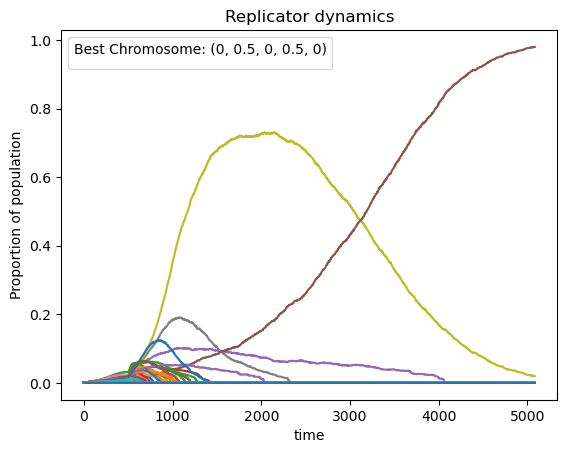

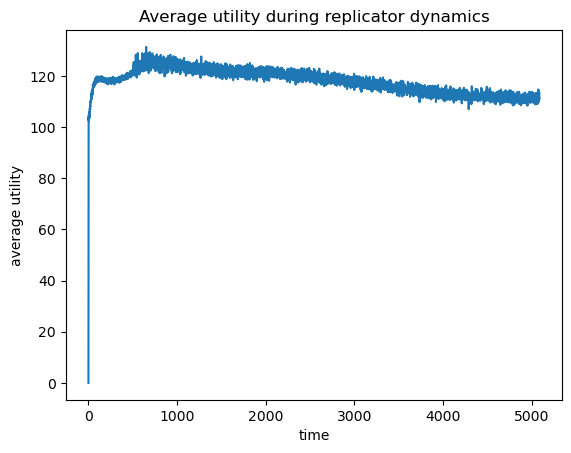

In [ ]:
import matplotlib.pyplot as plt
# print evolution
fig, axes = plt.subplots(1,1)
timesteps_plot = np.arange(nr_timesteps)
for i in range(nr_of_strategies):
    axes.plot(timesteps_plot, population_proportions[i,:nr_timesteps])

# Identify the strategy with the highest population proportion in the last timestep
highest_population_strategy_idx = np.argmax(population_proportions[:, nr_timesteps])
highest_population_strategy = strategies[highest_population_strategy_idx]
highest_population_chromosome = all_combinations[highest_population_strategy - 1]  

# plot replicator dynamics
legend_text = f"Best Chromosome: {highest_population_chromosome}"
axes.legend(loc="upper left", title=legend_text)
axes.set_xlabel("time")
axes.set_ylabel("Proportion of population")
axes.set_title("Replicator dynamics")
plt.show()

# plot utility over time
fig, axes = plt.subplots(1,1)
axes.plot(timesteps_plot, average_utility_over_time[:nr_timesteps])
axes.set_xlabel("time")
axes.set_ylabel("average utility")
axes.set_title("Average utility during replicator dynamics")
plt.show()


